Some code in this notebook has been adapted from the work of Zhongy et al. and Greydanus et al. and from the report and code of Jonas Perolini.

Their code is available in the following repositories :[
Symplectic-ODENet](https://github.com/Physics-aware-AI/Symplectic-ODENet) and [hamiltonian-nn](https://github.com/greydanus/hamiltonian-nn)


# Imports & Setting up directories

In [1]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    PATH = "./"  # './drive/MyDrive/1_SP_Ham_func/'
    from google.colab import drive

    drive.mount("/content/drive")

    %cd /content/drive/MyDrive/1_SP_Ham_func/furuta_pendulum/
    %pip install torchdiffeq
    from src.data import *
    from src.dynamics import *
    from src.models import *
    from src.train import *
    from src.plots import *
    from src.trajectories import *
    from src.utils import *
else:
    import sys

    sys.path.insert(0, "..")
    import os

    PATH = "../"
    from src.data import *
    from src.dynamics import *
    from src.models import *
    from src.train import *
    from src.plots import *
    from src.trajectories import *
    from src.utils import *

In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
import torch

from torch.optim.lr_scheduler import LinearLR

from torchdiffeq import odeint_adjoint as odeint_adjoint

# func must be a nn.Module when using the adjoint method
from torchdiffeq import odeint as odeint

import time as time
import json
import os

# setting seeds

In [3]:
%load_ext autoreload
%autoreload 2

# Training

## 10k parameters - w horizon - with std rescaling (and loss) no clip

In [4]:
device = set_device()  # set it to gpu if it is available

# Parameters to generate the dataset
furuta_type = "real"  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which=furuta_type)
utype = None  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
gtype = None  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = "random_nozero"  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 125  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = "hamiltonian"
min_max_rescale = False  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 0]

# Parameters for the training procedure
resnet_config = None
alternating = False  # for Input_HNN, if G is a neural network, train
horizon_type = "auto"  # 'auto' or 'constant'
horizon = False  # if horizon_type == 'constant', use this horizon
loss_type = "L2"  # 'L2' or 'L2weighted'
collect_grads = False  # collect gradients in all layers at every epoch
# rescale the difference between nominal and train by the min max of train trajectory in loss function
rescale_loss = True
grad_clip = False  # activate gradient clipping
lr_schedule = False  # activate lr schedule
begin_decay = 600  # epoch at which lr starts decaying
weights = [1.0, 1.0, 1.0, 1.0]  # weights for the loss functions

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [200, 100, 100, 100, 100, 100]
epoch_number = sum(switch_steps)  # total number of training epochs

cpu


In [5]:
# generate train and test dataloader objects containing the trajectories
train_loader, test_loader = load_data_device(
    device,
    init_method,
    w_rescale,
    u_func,
    g_func,
    time_steps,
    shuffle=shuffle,
    num_trajectories=num_trajectories,
    coord_type=coord_type,
    proportion=proportion,
    batch_size=batch_size,
    Ts=Ts,
    noise_std=noise_std,
    C_q1=C_q1,
    C_q2=C_q2,
    g=g,
    Jr=Jr,
    Lr=Lr,
    Mp=Mp,
    Lp=Lp,
    min_max_rescale=min_max_rescale,
    rescale_dims=rescale_dims,
)

In [6]:
# initialise the model that will be trained
model_name = "simple_HNN"
H_net = MLP(
    input_dim=4, hidden_dim=70, nb_hidden_layers=2, output_dim=1, activation="x+sin(x)^2"
)  # load H model
model = simple_HNN(input_dim=4, H_net=H_net, device=device)  # load neural ODE model
model.to(device)  # send model to devie ( cpu or gpu )

# create file name from parameters
num_params = count_parameters(model)

save_prefix = name_from_params(
    Ts,
    rescale_loss,
    weights,
    epoch_number,
    num_params,
    utype,
    model_name,
    num_trajectories,
    furuta_type,
    noise_std,
    grad_clip,
    lr_schedule,
    C_q1,
    C_q2,
    horizon,
    min_max_rescale,
)

# print some information on the training and file name
print("Total number of epochs:", epoch_number)
print("H_net number of parameters :", num_params)
print("Save file prefix : ", save_prefix)

# Sanity check
is_same_size(horizon_list, switch_steps)

Total number of epochs: 700
H_net number of parameters : 10363
Save file prefix :  simple_HNN_noinput_125traj_real_noise0.0_700e_p10k_Ts0.005_nodissip_rescaledloss_
horizon_list and switch_steps have the same size


horizon length : 50
min max values updated


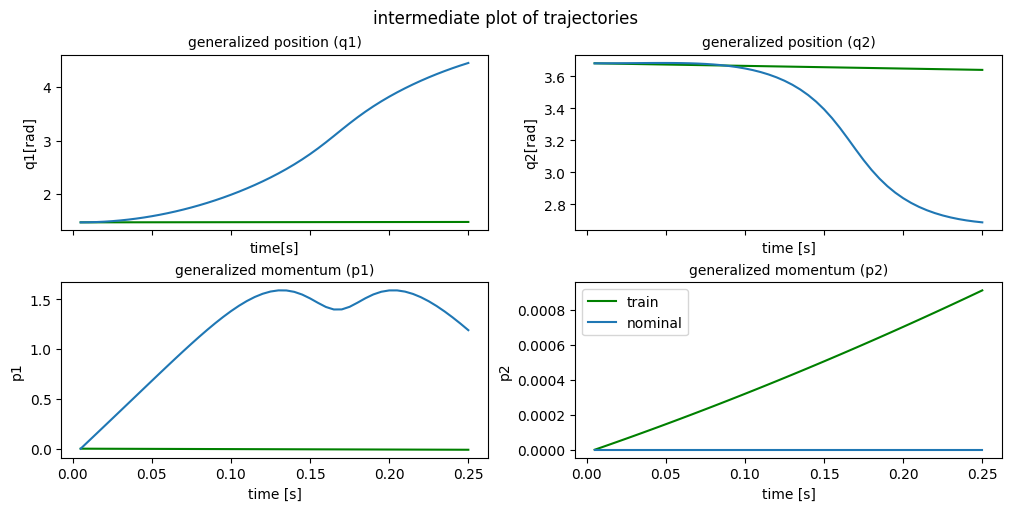

plot time : 0.6104080677032471
min max values updated
epoch    0 | train time 1.35 | train loss 1.023954e+00 | test loss 1.014454e+00 | test time 0.21  
epoch    1 | train time 0.86 | train loss 1.011844e+00 
epoch    2 | train time 0.69 | train loss 9.996483e-01 
epoch    3 | train time 0.66 | train loss 9.870130e-01 
epoch    4 | train time 0.62 | train loss 9.736069e-01 
epoch    5 | train time 0.70 | train loss 9.591659e-01 
epoch    6 | train time 0.75 | train loss 9.434860e-01 
epoch    7 | train time 0.70 | train loss 9.264267e-01 
epoch    8 | train time 0.67 | train loss 9.079258e-01 
epoch    9 | train time 0.69 | train loss 8.880013e-01 


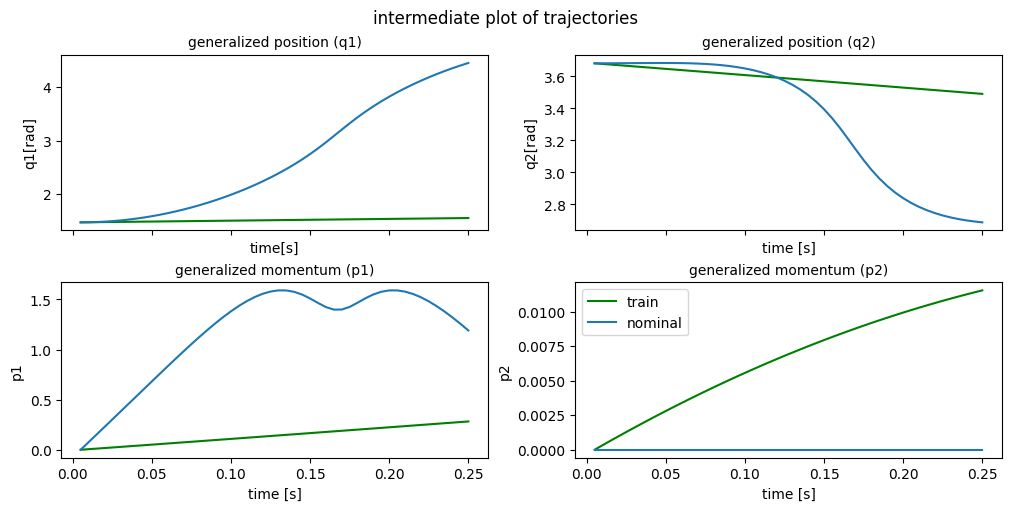

plot time : 0.593712329864502
epoch   10 | train time 1.31 | train loss 8.667370e-01 | test loss 8.460800e-01 | test time 0.23  
epoch   11 | train time 0.68 | train loss 8.442714e-01 
epoch   12 | train time 0.72 | train loss 8.207771e-01 
epoch   13 | train time 0.67 | train loss 7.964394e-01 
epoch   14 | train time 0.68 | train loss 7.714339e-01 
epoch   15 | train time 0.68 | train loss 7.459196e-01 
epoch   16 | train time 0.69 | train loss 7.200711e-01 
epoch   17 | train time 0.73 | train loss 6.941212e-01 
epoch   18 | train time 0.68 | train loss 6.683641e-01 
epoch   19 | train time 0.69 | train loss 6.430960e-01 


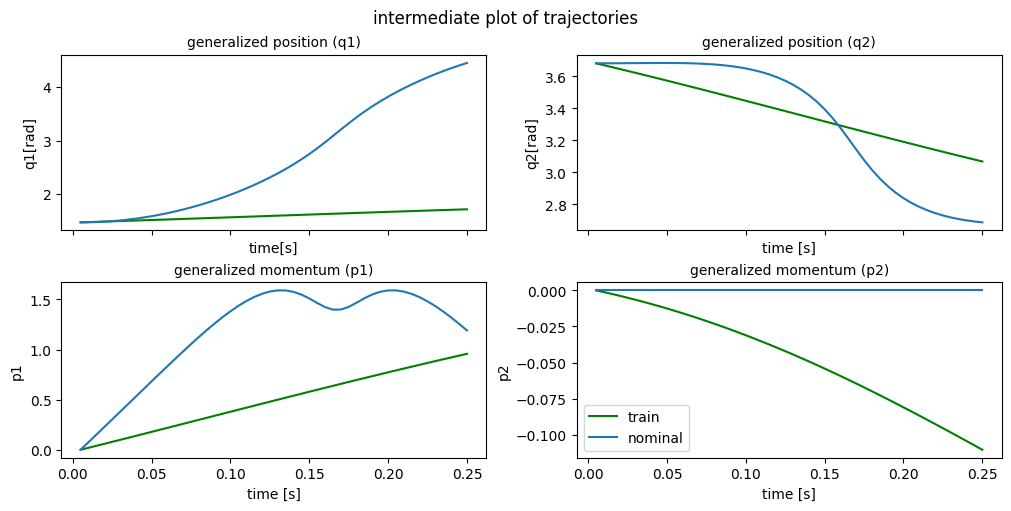

plot time : 0.5958998203277588
epoch   20 | train time 1.33 | train loss 6.185401e-01 | test loss 5.867691e-01 | test time 0.26  


KeyboardInterrupt: 

In [8]:
stats = train(
    device=device,
    model=model,
    Ts=Ts,
    train_loader=train_loader,
    test_loader=test_loader,
    w=torch.tensor(weights, device=device),
    grad_clip=grad_clip,
    lr_schedule=lr_schedule,
    begin_decay=begin_decay,
    resnet_config=resnet_config,
    
    alternating=alternating,
    horizon=horizon,
    horizon_type=horizon_type,
    horizon_list=horizon_list,
    switch_steps=switch_steps,
    epochs=epoch_number,
    loss_type=loss_type,
    collect_grads=collect_grads,
    rescale_loss=rescale_loss,
    rescale_dims=rescale_dims,
)

In [ ]:
if collect_grads:
    plot_grads(stats)

In [ ]:
# set all paths and create folders :
model_path = PATH + "data/" + save_prefix + "/"
stats_path = PATH + "data/" + save_prefix + "/"
plot_path = PATH + "data/" + save_prefix + "/img/"
train_loader_path = PATH + "data/" + save_prefix + "/datasets/"
test_loader_path = PATH + "data/" + save_prefix + "/datasets/"
os.makedirs(model_path, exist_ok=True)
os.makedirs(stats_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)
os.makedirs(train_loader_path, exist_ok=True)
os.makedirs(test_loader_path, exist_ok=True)

In [ ]:
torch.save(train_loader, train_loader_path + "train_loader.pt")
if test_loader is not None:
    torch.save(test_loader, test_loader_path + "test_loader.pt")

# save model to disk
torch.save(model.state_dict(), model_path + "model")

# save the stats
save_stats(stats, stats_path + "stats.txt")

In [ ]:
# train_loader = torch.load(train_loader_path)
# test_loader = torch.load(test_loader_path)
# # loads the stats
# stats = read_dict(PATH, stats_path)
# # load the model from disk
# model.load_state_dict(torch.load(PATH+model_path))
# model.eval()

In [ ]:
loss_train = stats["train_loss"]
loss_test = stats["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    file_path=plot_path + "/LOSS_train_test.png",
    title="train and test loss per epoch",
    horizons=False,
    switch_steps=switch_steps,
)

train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    file_path=plot_path + "/LOSS_train_test_warrows.png",
    title="train and test loss per epoch",
    horizons=horizon_list[:-1],
    switch_steps=switch_steps,
)

In [ ]:
# show train and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(
        device,
        model,
        u_func,
        g_func,
        utype,
        gtype,
        data_loader_t=train_loader,
        t_max=horizon_list[-1],
        n=n,
        C_q1=C_q1,
        C_q2=C_q2,
        g=g,
        Jr=Jr,
        Lr=Lr,
        Mp=Mp,
        Lp=Lp,
        t_plot=time_steps,
        show_pred=True,
        H_or_Input="input",
        title="Train set trajectories",
        file_path=plot_path + "/TRAJECTORIES_train_set" + str(n) + ".png",
        w_rescale=w_rescale,
    )

In [ ]:
# show only training portion
for n in [0, 50, 70]:
    plot_furuta_hat_nom(
        device,
        model,
        u_func,
        g_func,
        utype,
        gtype,
        data_loader_t=train_loader,
        t_max=horizon_list[-1],
        n=n,
        C_q1=C_q1,
        C_q2=C_q2,
        g=g,
        Jr=Jr,
        Lr=Lr,
        Mp=Mp,
        Lp=Lp,
        t_plot=horizon_list[-1],
        show_pred=False,
        title="Train set trajectories",
        file_path=plot_path + "/TRAJECTORIES_train_set" + str(n) + "nopred.png",
        w_rescale=w_rescale,
    )

## 10k parameters - w horizon - with rescaling - with grad clipping

In [ ]:
device = set_device()  # set it to gpu if it is available

# Parameters to generate the dataset
furuta_type = "real"  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which=furuta_type)
utype = None  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
gtype = None  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = "random_nozero"  # 'random_nozero' # 'random_closetopi'
time_steps = 800
num_trajectories = 125
proportion = 0.8
batch_size = 100
w_rescale = [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False
coord_type = "hamiltonian"
rescale_dims = [1, 1, 1, 0]
min_max_rescale = True

# Parameters for the training procedure
resnet_config = None
alternating = False  # for Input_HNN, if G is a neural network, train
horizon_type = "auto"  # 'auto' or 'constant'
horizon = False  # if horizon_type == 'constant', use this horizon
loss_type = "L2"  # 'L2' or 'L2weighted'
collect_grads = False  # collect gradients in all layers at every epoch
# rescale the difference between nominal and train by the min max of train trajectory in loss function
rescale_loss = True
grad_clip = True  # activate gradient clipping
lr_schedule = False  # activate lr schedule
begin_decay = 600  # epoch at which lr starts decaying
weights = [1.0, 1.0, 1.0, 1.0]  # weights for the loss functions

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [200, 100, 100, 100, 100, 100]
epoch_number = sum(switch_steps)

In [ ]:
# generate train and test dataloader objects containing the trajectories
train_loader, test_loader = load_data_device(
    device,
    init_method,
    w_rescale,
    u_func,
    g_func,
    time_steps,
    shuffle=shuffle,
    num_trajectories=num_trajectories,
    coord_type=coord_type,
    proportion=proportion,
    batch_size=batch_size,
    Ts=Ts,
    noise_std=noise_std,
    C_q1=C_q1,
    C_q2=C_q2,
    g=g,
    Jr=Jr,
    Lr=Lr,
    Mp=Mp,
    Lp=Lp,
    min_max_rescale=min_max_rescale,
    rescale_dims=rescale_dims,
)

In [ ]:
# initialise the model that will be trained
model_name = "simple_HNN"
H_net = MLP(
    input_dim=4, hidden_dim=70, nb_hidden_layers=2, output_dim=1, activation="x+sin(x)^2"
)  # load H model
model = simple_HNN(input_dim=4, H_net=H_net, device=device)  # load neural ODE model
model.to(device)  # send model to devie ( cpu or gpu )

# create file name from parameters
num_params = count_parameters(model)

save_prefix = name_from_params(
    Ts,
    rescale_loss,
    weights,
    epoch_number,
    num_params,
    utype,
    model_name,
    num_trajectories,
    furuta_type,
    noise_std,
    grad_clip,
    lr_schedule,
    C_q1,
    C_q2,
    horizon,
    min_max_rescale,
)

# print some information on the training and file name
print("Total number of epochs:", epoch_number)
print("H_net number of parameters :", num_params)
print("Save file prefix : ", save_prefix)

# Sanity check
is_same_size(horizon_list, switch_steps)

In [ ]:
stats = train(
    device=device,
    model=model,
    Ts=Ts,
    train_loader=train_loader,
    test_loader=test_loader,
    w=torch.tensor(weights, device=device),
    grad_clip=grad_clip,
    lr_schedule=lr_schedule,
    begin_decay=begin_decay,
    resnet_config=resnet_config,
    
    alternating=alternating,
    horizon=horizon,
    horizon_type=horizon_type,
    horizon_list=horizon_list,
    switch_steps=switch_steps,
    epochs=epoch_number,
    loss_type=loss_type,
    collect_grads=collect_grads,
    rescale_loss=rescale_loss,
    rescale_dims=rescale_dims,
)

In [ ]:
if collect_grads:
    plot_grads(stats)

In [ ]:
# set all paths and create folders :
model_path = PATH + "data/" + save_prefix + "/"
stats_path = PATH + "data/" + save_prefix + "/"
plot_path = PATH + "data/" + save_prefix + "/img/"
train_loader_path = PATH + "data/" + save_prefix + "/datasets/"
test_loader_path = PATH + "data/" + save_prefix + "/datasets/"
os.makedirs(model_path, exist_ok=True)
os.makedirs(stats_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)
os.makedirs(train_loader_path, exist_ok=True)
os.makedirs(test_loader_path, exist_ok=True)

In [ ]:
torch.save(train_loader, train_loader_path + "train_loader.pt")
if test_loader is not None:
    torch.save(test_loader, test_loader_path + "test_loader.pt")

# save model to disk
torch.save(model.state_dict(), model_path + "model")

# save the stats
save_stats(stats, stats_path + "stats.txt")

In [ ]:
# train_loader = torch.load(train_loader_path)
# test_loader = torch.load(test_loader_path)
# # loads the stats
# stats = read_dict(PATH, stats_path)
# # load the model from disk
# model.load_state_dict(torch.load(PATH+model_path))
# model.eval()

In [ ]:
loss_train = stats["train_loss"]
loss_test = stats["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    file_path=plot_path + "/LOSS_train_test.png",
    title="train and test loss per epoch",
    horizons=False,
    switch_steps=switch_steps,
)

train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    file_path=plot_path + "/LOSS_train_test_warrows.png",
    title="train and test loss per epoch",
    horizons=horizon_list[:-1],
    switch_steps=switch_steps,
)

In [ ]:
# show train and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(
        device,
        model,
        u_func,
        g_func,
        utype,
        gtype,
        data_loader_t=train_loader,
        t_max=horizon_list[-1],
        n=n,
        C_q1=C_q1,
        C_q2=C_q2,
        g=g,
        Jr=Jr,
        Lr=Lr,
        Mp=Mp,
        Lp=Lp,
        t_plot=time_steps,
        show_pred=True,
        H_or_Input="input",
        title="Train set trajectories",
        file_path=plot_path + "/TRAJECTORIES_train_set" + str(n) + ".png",
        w_rescale=w_rescale,
    )

In [ ]:
# show only training portion
for n in [0, 50, 70]:
    plot_furuta_hat_nom(
        device,
        model,
        u_func,
        g_func,
        utype,
        gtype,
        data_loader_t=train_loader,
        t_max=horizon_list[-1],
        n=n,
        C_q1=C_q1,
        C_q2=C_q2,
        g=g,
        Jr=Jr,
        Lr=Lr,
        Mp=Mp,
        Lp=Lp,
        t_plot=horizon_list[-1],
        show_pred=False,
        title="Train set trajectories",
        file_path=plot_path + "/TRAJECTORIES_train_set" + str(n) + "nopred.png",
        w_rescale=w_rescale,
    )

## 30k parameters - w horizon no rescaling 

In [ ]:
device = set_device()  # set it to gpu if it is available

# Parameters to generate the dataset
furuta_type = "real"  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which=furuta_type)
utype = None  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
gtype = None  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = "random_nozero"  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 125  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [
    1,
    1,
    1,
    1,
]  # [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = "hamiltonian"
min_max_rescale = False  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 0]

# Parameters for the training procedure
resnet_config = None
alternating = False  # for Input_HNN, if G is a neural network, train
horizon_type = "auto"  # 'auto' or 'constant'
horizon = False  # if horizon_type == 'constant', use this horizon
loss_type = "L2"  # 'L2' or 'L2weighted'
collect_grads = False  # collect gradients in all layers at every epoch
# rescale the difference between nominal and train by the min max of train trajectory in loss function
rescale_loss = False
grad_clip = False  # activate gradient clipping
lr_schedule = False  # activate lr schedule
begin_decay = 600  # epoch at which lr starts decaying
weights = [1.0, 1.0, 1.0, 1.0]  # weights for the loss functions

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [200, 100, 100, 100, 100, 100]
epoch_number = sum(switch_steps)  # total number of training epochs

In [ ]:
# generate train and test dataloader objects containing the trajectories
train_loader, test_loader = load_data_device(
    device,
    init_method,
    w_rescale,
    u_func,
    g_func,
    time_steps,
    shuffle=shuffle,
    num_trajectories=num_trajectories,
    coord_type=coord_type,
    proportion=proportion,
    batch_size=batch_size,
    Ts=Ts,
    noise_std=noise_std,
    C_q1=C_q1,
    C_q2=C_q2,
    g=g,
    Jr=Jr,
    Lr=Lr,
    Mp=Mp,
    Lp=Lp,
    min_max_rescale=min_max_rescale,
    rescale_dims=rescale_dims,
)

In [ ]:
# initialise the model that will be trained
model_name = "simple_HNN"
H_net = MLP(
    input_dim=4, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation="x+sin(x)^2"
)  # load H model
model = simple_HNN(input_dim=4, H_net=H_net, device=device)  # load neural ODE model
model.to(device)  # send model to devie ( cpu or gpu )

# create file name from parameters
num_params = count_parameters(model)

save_prefix = name_from_params(
    Ts,
    rescale_loss,
    weights,
    epoch_number,
    num_params,
    utype,
    model_name,
    num_trajectories,
    furuta_type,
    noise_std,
    grad_clip,
    lr_schedule,
    C_q1,
    C_q2,
    horizon,
    min_max_rescale,
)

# print some information on the training and file name
print("Total number of epochs:", epoch_number)
print("H_net number of parameters :", num_params)
print("Save file prefix : ", save_prefix)

# Sanity check
is_same_size(horizon_list, switch_steps)

In [ ]:
stats = train(
    device=device,
    model=model,
    Ts=Ts,
    train_loader=train_loader,
    test_loader=test_loader,
    w=torch.tensor(weights, device=device),
    grad_clip=grad_clip,
    lr_schedule=lr_schedule,
    begin_decay=begin_decay,
    resnet_config=resnet_config,
    
    alternating=alternating,
    horizon=horizon,
    horizon_type=horizon_type,
    horizon_list=horizon_list,
    switch_steps=switch_steps,
    epochs=epoch_number,
    loss_type=loss_type,
    collect_grads=collect_grads,
    rescale_loss=rescale_loss,
    rescale_dims=rescale_dims,
)

In [ ]:
if collect_grads:
    plot_grads(stats)

In [ ]:
# set all paths and create folders :
model_path = PATH + "data/" + save_prefix + "/"
stats_path = PATH + "data/" + save_prefix + "/"
plot_path = PATH + "data/" + save_prefix + "/img/"
train_loader_path = PATH + "data/" + save_prefix + "/datasets/"
test_loader_path = PATH + "data/" + save_prefix + "/datasets/"
os.makedirs(model_path, exist_ok=True)
os.makedirs(stats_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)
os.makedirs(train_loader_path, exist_ok=True)
os.makedirs(test_loader_path, exist_ok=True)

In [ ]:
torch.save(train_loader, train_loader_path + "train_loader.pt")
if test_loader is not None:
    torch.save(test_loader, test_loader_path + "test_loader.pt")

# save model to disk
torch.save(model.state_dict(), model_path + "model")

# save the stats
save_stats(stats, stats_path + "stats.txt")

In [ ]:
# train_loader = torch.load(train_loader_path)
# test_loader = torch.load(test_loader_path)
# # loads the stats
# stats = read_dict(PATH, stats_path)
# # load the model from disk
# model.load_state_dict(torch.load(PATH+model_path))
# model.eval()

In [ ]:
loss_train = stats["train_loss"]
loss_test = stats["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    file_path=plot_path + "/LOSS_train_test.png",
    title="train and test loss per epoch",
    horizons=False,
    switch_steps=switch_steps,
)

train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    file_path=plot_path + "/LOSS_train_test_warrows.png",
    title="train and test loss per epoch",
    horizons=horizon_list[:-1],
    switch_steps=switch_steps,
)

In [ ]:
# show train and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(
        device,
        model,
        u_func,
        g_func,
        utype,
        gtype,
        data_loader_t=train_loader,
        t_max=horizon_list[-1],
        n=n,
        C_q1=C_q1,
        C_q2=C_q2,
        g=g,
        Jr=Jr,
        Lr=Lr,
        Mp=Mp,
        Lp=Lp,
        t_plot=time_steps,
        show_pred=True,
        H_or_Input="input",
        title="Train set trajectories",
        file_path=plot_path + "/TRAJECTORIES_train_set" + str(n) + ".png",
        w_rescale=w_rescale,
    )

In [ ]:
# show only training portion
for n in [0, 50, 70]:
    plot_furuta_hat_nom(
        device,
        model,
        u_func,
        g_func,
        utype,
        gtype,
        data_loader_t=train_loader,
        t_max=horizon_list[-1],
        n=n,
        C_q1=C_q1,
        C_q2=C_q2,
        g=g,
        Jr=Jr,
        Lr=Lr,
        Mp=Mp,
        Lp=Lp,
        t_plot=horizon_list[-1],
        show_pred=False,
        title="Train set trajectories",
        file_path=plot_path + "/TRAJECTORIES_train_set" + str(n) + "nopred.png",
        w_rescale=w_rescale,
    )

## 30k parameters - w horizon only loss rescaling no clipping (didnt work)

In [ ]:
device = set_device()  # set it to gpu if it is available

# Parameters to generate the dataset
furuta_type = "real"  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which=furuta_type)
utype = None  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
gtype = None  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = "random_nozero"  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 125  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [
    1,
    1,
    1,
    1,
]  # [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = "hamiltonian"
min_max_rescale = False  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 0]

# Parameters for the training procedure
resnet_config = None
alternating = False  # for Input_HNN, if G is a neural network, train
horizon_type = "auto"  # 'auto' or 'constant'
horizon = False  # if horizon_type == 'constant', use this horizon
loss_type = "L2"  # 'L2' or 'L2weighted'
collect_grads = False  # collect gradients in all layers at every epoch
# rescale the difference between nominal and train by the min max of train trajectory in loss function
rescale_loss = True
grad_clip = False  # activate gradient clipping
lr_schedule = False  # activate lr schedule
begin_decay = 600  # epoch at which lr starts decaying
weights = [1.0, 1.0, 1.0, 1.0]  # weights for the loss functions

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [200, 100, 100, 100, 100, 100]
epoch_number = sum(switch_steps)  # total number of training epochs

In [ ]:
# generate train and test dataloader objects containing the trajectories
train_loader, test_loader = load_data_device(
    device,
    init_method,
    w_rescale,
    u_func,
    g_func,
    time_steps,
    shuffle=shuffle,
    num_trajectories=num_trajectories,
    coord_type=coord_type,
    proportion=proportion,
    batch_size=batch_size,
    Ts=Ts,
    noise_std=noise_std,
    C_q1=C_q1,
    C_q2=C_q2,
    g=g,
    Jr=Jr,
    Lr=Lr,
    Mp=Mp,
    Lp=Lp,
    min_max_rescale=min_max_rescale,
    rescale_dims=rescale_dims,
)

In [ ]:
# initialise the model that will be trained
model_name = "simple_HNN"
H_net = MLP(
    input_dim=4, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation="x+sin(x)^2"
)  # load H model
model = simple_HNN(input_dim=4, H_net=H_net, device=device)  # load neural ODE model
model.to(device)  # send model to devie ( cpu or gpu )

# create file name from parameters
num_params = count_parameters(model)

save_prefix = name_from_params(
    Ts,
    rescale_loss,
    weights,
    epoch_number,
    num_params,
    utype,
    model_name,
    num_trajectories,
    furuta_type,
    noise_std,
    grad_clip,
    lr_schedule,
    C_q1,
    C_q2,
    horizon,
    min_max_rescale,
)

# print some information on the training and file name
print("Total number of epochs:", epoch_number)
print("H_net number of parameters :", num_params)
print("Save file prefix : ", save_prefix)

# Sanity check
is_same_size(horizon_list, switch_steps)

In [ ]:
save_prefix = save_prefix + "nostdrescale"

In [ ]:
stats = train(
    device=device,
    model=model,
    Ts=Ts,
    train_loader=train_loader,
    test_loader=test_loader,
    w=torch.tensor(weights, device=device),
    grad_clip=grad_clip,
    lr_schedule=lr_schedule,
    begin_decay=begin_decay,
    resnet_config=resnet_config,
    
    alternating=alternating,
    horizon=horizon,
    horizon_type=horizon_type,
    horizon_list=horizon_list,
    switch_steps=switch_steps,
    epochs=epoch_number,
    loss_type=loss_type,
    collect_grads=collect_grads,
    rescale_loss=rescale_loss,
    rescale_dims=rescale_dims,
)

In [ ]:
if collect_grads:
    plot_grads(stats)

In [ ]:
# set all paths and create folders :
model_path = PATH + "data/" + save_prefix + "/"
stats_path = PATH + "data/" + save_prefix + "/"
plot_path = PATH + "data/" + save_prefix + "/img/"
train_loader_path = PATH + "data/" + save_prefix + "/datasets/"
test_loader_path = PATH + "data/" + save_prefix + "/datasets/"
os.makedirs(model_path, exist_ok=True)
os.makedirs(stats_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)
os.makedirs(train_loader_path, exist_ok=True)
os.makedirs(test_loader_path, exist_ok=True)

In [ ]:
torch.save(train_loader, train_loader_path + "train_loader.pt")
if test_loader is not None:
    torch.save(test_loader, test_loader_path + "test_loader.pt")

# save model to disk
torch.save(model.state_dict(), model_path + "model")

# save the stats
save_stats(stats, stats_path + "stats.txt")

In [ ]:
# train_loader = torch.load(train_loader_path)
# test_loader = torch.load(test_loader_path)
# # loads the stats
# stats = read_dict(PATH, stats_path)
# # load the model from disk
# model.load_state_dict(torch.load(PATH+model_path))
# model.eval()

In [ ]:
loss_train = stats["train_loss"]
loss_test = stats["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    file_path=plot_path + "/LOSS_train_test.png",
    title="train and test loss per epoch",
    horizons=False,
    switch_steps=switch_steps,
)

train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    file_path=plot_path + "/LOSS_train_test_warrows.png",
    title="train and test loss per epoch",
    horizons=horizon_list[:-1],
    switch_steps=switch_steps,
)

In [ ]:
# show train and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(
        device,
        model,
        u_func,
        g_func,
        utype,
        gtype,
        data_loader_t=train_loader,
        t_max=horizon_list[-1],
        n=n,
        C_q1=C_q1,
        C_q2=C_q2,
        g=g,
        Jr=Jr,
        Lr=Lr,
        Mp=Mp,
        Lp=Lp,
        t_plot=time_steps,
        show_pred=True,
        H_or_Input="input",
        title="Train set trajectories",
        file_path=plot_path + "/TRAJECTORIES_train_set" + str(n) + ".png",
        w_rescale=w_rescale,
    )

In [ ]:
# show only training portion
for n in [0, 50, 70]:
    plot_furuta_hat_nom(
        device,
        model,
        u_func,
        g_func,
        utype,
        gtype,
        data_loader_t=train_loader,
        t_max=horizon_list[-1],
        n=n,
        C_q1=C_q1,
        C_q2=C_q2,
        g=g,
        Jr=Jr,
        Lr=Lr,
        Mp=Mp,
        Lp=Lp,
        t_plot=horizon_list[-1],
        show_pred=False,
        title="Train set trajectories",
        file_path=plot_path + "/TRAJECTORIES_train_set" + str(n) + "nopred.png",
        w_rescale=w_rescale,
    )

## 30k parameters - w horizon - std rescaling (and loss) no clipping


In [ ]:
device = set_device()  # set it to gpu if it is available

# Parameters to generate the dataset
furuta_type = "real"  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which=furuta_type)
utype = None  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
gtype = None  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = "random_nozero"  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 125  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = "hamiltonian"
min_max_rescale = False  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 0]

# Parameters for the training procedure
resnet_config = None
alternating = False  # for Input_HNN, if G is a neural network, train
horizon_type = "auto"  # 'auto' or 'constant'
horizon = False  # if horizon_type == 'constant', use this horizon
loss_type = "L2"  # 'L2' or 'L2weighted'
collect_grads = False  # collect gradients in all layers at every epoch
# rescale the difference between nominal and train by the min max of train trajectory in loss function
rescale_loss = True
grad_clip = False  # activate gradient clipping
lr_schedule = False  # activate lr schedule
begin_decay = 600  # epoch at which lr starts decaying
weights = [1.0, 1.0, 1.0, 1.0]  # weights for the loss functions

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [200, 100, 100, 100, 100, 100]
epoch_number = sum(switch_steps)  # total number of training epochs

In [ ]:
# generate train and test dataloader objects containing the trajectories
train_loader, test_loader = load_data_device(
    device,
    init_method,
    w_rescale,
    u_func,
    g_func,
    time_steps,
    shuffle=shuffle,
    num_trajectories=num_trajectories,
    coord_type=coord_type,
    proportion=proportion,
    batch_size=batch_size,
    Ts=Ts,
    noise_std=noise_std,
    C_q1=C_q1,
    C_q2=C_q2,
    g=g,
    Jr=Jr,
    Lr=Lr,
    Mp=Mp,
    Lp=Lp,
    min_max_rescale=min_max_rescale,
    rescale_dims=rescale_dims,
)

In [ ]:
# initialise the model that will be trained
model_name = "simple_HNN"
H_net = MLP(
    input_dim=4, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation="x+sin(x)^2"
)  # load H model
model = simple_HNN(input_dim=4, H_net=H_net, device=device)  # load neural ODE model
model.to(device)  # send model to devie ( cpu or gpu )

# create file name from parameters
num_params = count_parameters(model)

save_prefix = name_from_params(
    Ts,
    rescale_loss,
    weights,
    epoch_number,
    num_params,
    utype,
    model_name,
    num_trajectories,
    furuta_type,
    noise_std,
    grad_clip,
    lr_schedule,
    C_q1,
    C_q2,
    horizon,
    min_max_rescale,
)

# print some information on the training and file name
print("Total number of epochs:", epoch_number)
print("H_net number of parameters :", num_params)
print("Save file prefix : ", save_prefix)

# Sanity check
is_same_size(horizon_list, switch_steps)

In [ ]:
stats = train(
    device=device,
    model=model,
    Ts=Ts,
    train_loader=train_loader,
    test_loader=test_loader,
    w=torch.tensor(weights, device=device),
    grad_clip=grad_clip,
    lr_schedule=lr_schedule,
    begin_decay=begin_decay,
    resnet_config=resnet_config,
    
    alternating=alternating,
    horizon=horizon,
    horizon_type=horizon_type,
    horizon_list=horizon_list,
    switch_steps=switch_steps,
    epochs=epoch_number,
    loss_type=loss_type,
    collect_grads=collect_grads,
    rescale_loss=rescale_loss,
    rescale_dims=rescale_dims,
)

In [ ]:
if collect_grads:
    plot_grads(stats)

In [ ]:
# set all paths and create folders :
model_path = PATH + "data/" + save_prefix + "/"
stats_path = PATH + "data/" + save_prefix + "/"
plot_path = PATH + "data/" + save_prefix + "/img/"
train_loader_path = PATH + "data/" + save_prefix + "/datasets/"
test_loader_path = PATH + "data/" + save_prefix + "/datasets/"
os.makedirs(model_path, exist_ok=True)
os.makedirs(stats_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)
os.makedirs(train_loader_path, exist_ok=True)
os.makedirs(test_loader_path, exist_ok=True)

In [ ]:
torch.save(train_loader, train_loader_path + "train_loader.pt")
if test_loader is not None:
    torch.save(test_loader, test_loader_path + "test_loader.pt")

# save model to disk
torch.save(model.state_dict(), model_path + "model")

# save the stats
save_stats(stats, stats_path + "stats.txt")

In [ ]:
# train_loader = torch.load(train_loader_path)
# test_loader = torch.load(test_loader_path)
# # loads the stats
# stats = read_dict(PATH, stats_path)
# # load the model from disk
# model.load_state_dict(torch.load(PATH+model_path))
# model.eval()

In [ ]:
loss_train = stats["train_loss"]
loss_test = stats["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    file_path=plot_path + "/LOSS_train_test.png",
    title="train and test loss per epoch",
    horizons=False,
    switch_steps=switch_steps,
)

train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    file_path=plot_path + "/LOSS_train_test_warrows.png",
    title="train and test loss per epoch",
    horizons=horizon_list[:-1],
    switch_steps=switch_steps,
)

In [ ]:
# show train and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(
        device,
        model,
        u_func,
        g_func,
        utype,
        gtype,
        data_loader_t=train_loader,
        t_max=horizon_list[-1],
        n=n,
        C_q1=C_q1,
        C_q2=C_q2,
        g=g,
        Jr=Jr,
        Lr=Lr,
        Mp=Mp,
        Lp=Lp,
        t_plot=time_steps,
        show_pred=True,
        H_or_Input="input",
        title="Train set trajectories",
        file_path=plot_path + "/TRAJECTORIES_train_set" + str(n) + ".png",
        w_rescale=w_rescale,
    )

In [ ]:
# show only training portion
for n in [0, 50, 70]:
    plot_furuta_hat_nom(
        device,
        model,
        u_func,
        g_func,
        utype,
        gtype,
        data_loader_t=train_loader,
        t_max=horizon_list[-1],
        n=n,
        C_q1=C_q1,
        C_q2=C_q2,
        g=g,
        Jr=Jr,
        Lr=Lr,
        Mp=Mp,
        Lp=Lp,
        t_plot=horizon_list[-1],
        show_pred=False,
        title="Train set trajectories",
        file_path=plot_path + "/TRAJECTORIES_train_set" + str(n) + "nopred.png",
        w_rescale=w_rescale,
    )

## 30k parameters - w horizon - with all rescaling no clipping

In [ ]:
device = set_device()  # set it to gpu if it is available

# Parameters to generate the dataset
furuta_type = "real"  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which=furuta_type)
utype = None  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
gtype = None  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = "random_nozero"  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 125  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [
    1,
    1,
    1,
    1,
]  # [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = "hamiltonian"
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 0]

# Parameters for the training procedure
resnet_config = None
alternating = False  # for Input_HNN, if G is a neural network, train
horizon_type = "auto"  # 'auto' or 'constant'
horizon = False  # if horizon_type == 'constant', use this horizon
loss_type = "L2"  # 'L2' or 'L2weighted'
collect_grads = False  # collect gradients in all layers at every epoch
# rescale the difference between nominal and train by the min max of train trajectory in loss function
rescale_loss = True
grad_clip = False  # activate gradient clipping
lr_schedule = False  # activate lr schedule
begin_decay = 600  # epoch at which lr starts decaying
weights = [1.0, 1.0, 1.0, 1.0]  # weights for the loss functions

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [200, 100, 100, 100, 100, 100]
epoch_number = sum(switch_steps)  # total number of training epochs

In [ ]:
# generate train and test dataloader objects containing the trajectories
train_loader, test_loader = load_data_device(
    device,
    init_method,
    w_rescale,
    u_func,
    g_func,
    time_steps,
    shuffle=shuffle,
    num_trajectories=num_trajectories,
    coord_type=coord_type,
    proportion=proportion,
    batch_size=batch_size,
    Ts=Ts,
    noise_std=noise_std,
    C_q1=C_q1,
    C_q2=C_q2,
    g=g,
    Jr=Jr,
    Lr=Lr,
    Mp=Mp,
    Lp=Lp,
    min_max_rescale=min_max_rescale,
    rescale_dims=rescale_dims,
)

In [ ]:
# initialise the model that will be trained
model_name = "simple_HNN"
H_net = MLP(
    input_dim=4, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation="x+sin(x)^2"
)  # load H model
model = simple_HNN(input_dim=4, H_net=H_net, device=device)  # load neural ODE model
model.to(device)  # send model to devie ( cpu or gpu )

# create file name from parameters
num_params = count_parameters(model)

save_prefix = name_from_params(
    Ts,
    rescale_loss,
    weights,
    epoch_number,
    num_params,
    utype,
    model_name,
    num_trajectories,
    furuta_type,
    noise_std,
    grad_clip,
    lr_schedule,
    C_q1,
    C_q2,
    horizon,
    min_max_rescale,
)

# print some information on the training and file name
print("Total number of epochs:", epoch_number)
print("H_net number of parameters :", num_params)
print("Save file prefix : ", save_prefix)

# Sanity check
is_same_size(horizon_list, switch_steps)

In [ ]:
stats = train(
    device=device,
    model=model,
    Ts=Ts,
    train_loader=train_loader,
    test_loader=test_loader,
    w=torch.tensor(weights, device=device),
    grad_clip=grad_clip,
    lr_schedule=lr_schedule,
    begin_decay=begin_decay,
    resnet_config=resnet_config,
    
    alternating=alternating,
    horizon=horizon,
    horizon_type=horizon_type,
    horizon_list=horizon_list,
    switch_steps=switch_steps,
    epochs=epoch_number,
    loss_type=loss_type,
    collect_grads=collect_grads,
    rescale_loss=rescale_loss,
    rescale_dims=rescale_dims,
)

In [ ]:
if collect_grads:
    plot_grads(stats)

In [ ]:
# set all paths and create folders :
model_path = PATH + "data/" + save_prefix + "/"
stats_path = PATH + "data/" + save_prefix + "/"
plot_path = PATH + "data/" + save_prefix + "/img/"
train_loader_path = PATH + "data/" + save_prefix + "/datasets/"
test_loader_path = PATH + "data/" + save_prefix + "/datasets/"
os.makedirs(model_path, exist_ok=True)
os.makedirs(stats_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)
os.makedirs(train_loader_path, exist_ok=True)
os.makedirs(test_loader_path, exist_ok=True)

In [ ]:
torch.save(train_loader, train_loader_path + "train_loader.pt")
if test_loader is not None:
    torch.save(test_loader, test_loader_path + "test_loader.pt")

# save model to disk
torch.save(model.state_dict(), model_path + "model")

# save the stats
save_stats(stats, stats_path + "stats.txt")

In [ ]:
# train_loader = torch.load(train_loader_path)
# test_loader = torch.load(test_loader_path)
# # loads the stats
# stats = read_dict(PATH, stats_path)
# # load the model from disk
# model.load_state_dict(torch.load(PATH+model_path))
# model.eval()

In [ ]:
loss_train = stats["train_loss"]
loss_test = stats["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    file_path=plot_path + "/LOSS_train_test.png",
    title="train and test loss per epoch",
    horizons=False,
    switch_steps=switch_steps,
)

train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    file_path=plot_path + "/LOSS_train_test_warrows.png",
    title="train and test loss per epoch",
    horizons=horizon_list[:-1],
    switch_steps=switch_steps,
)

In [ ]:
# show train and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(
        device,
        model,
        u_func,
        g_func,
        utype,
        gtype,
        data_loader_t=train_loader,
        t_max=horizon_list[-1],
        n=n,
        C_q1=C_q1,
        C_q2=C_q2,
        g=g,
        Jr=Jr,
        Lr=Lr,
        Mp=Mp,
        Lp=Lp,
        t_plot=time_steps,
        show_pred=True,
        H_or_Input="input",
        title="Train set trajectories",
        file_path=plot_path + "/TRAJECTORIES_train_set" + str(n) + ".png",
        w_rescale=w_rescale,
    )

In [ ]:
# show only training portion
for n in [0, 50, 70]:
    plot_furuta_hat_nom(
        device,
        model,
        u_func,
        g_func,
        utype,
        gtype,
        data_loader_t=train_loader,
        t_max=horizon_list[-1],
        n=n,
        C_q1=C_q1,
        C_q2=C_q2,
        g=g,
        Jr=Jr,
        Lr=Lr,
        Mp=Mp,
        Lp=Lp,
        t_plot=horizon_list[-1],
        show_pred=False,
        title="Train set trajectories",
        file_path=plot_path + "/TRAJECTORIES_train_set" + str(n) + "nopred.png",
        w_rescale=w_rescale,
    )

## 30k parameters - w horizon - with rescaling - with grad clipping

In [ ]:
device = set_device()  # set it to gpu if it is available

# Parameters to generate the dataset
furuta_type = "real"  # 'real' or 'fake'
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which=furuta_type)
utype = None  # 'chirp' or 'sine' or 'tanh' or 'multisine' or 'step' or None
u_func = U_FUNC(utype=utype)  # instantiate the input function u(t)
gtype = None  # 'simple' or None
# instantiate the input function G(q,p) (here it is constant)
g_func = G_FUNC(gtype=gtype)
init_method = "random_nozero"  # 'random_nozero' # 'random_closetopi'
time_steps = 800  # length of a trajectory
num_trajectories = 125  # number of trajectories in total
proportion = 0.8  # train test proportion
batch_size = 100  # batch size used by dataloader
w_rescale = [
    1,
    1,
    1,
    1,
]  # [1, 1000, 1, 10000]  # [1, 1000, 1, 10000]  # [1, 9000, 1, 10000]
shuffle = False  # shuffle sample in the batches between epochs
# 'hamiltonian' or 'newtonian', newtonian if you want [q1,q1_dot,q2,q2_dot]
coord_type = "hamiltonian"
min_max_rescale = True  # rescale the training trajectories
# which dimensions to rescale if using min_max_rescale, so that nothing is divided by zero
rescale_dims = [1, 1, 1, 0]

# Parameters for the training procedure
resnet_config = None
alternating = False  # for Input_HNN, if G is a neural network, train
horizon_type = "auto"  # 'auto' or 'constant'
horizon = False  # if horizon_type == 'constant', use this horizon
loss_type = "L2"  # 'L2' or 'L2weighted'
collect_grads = False  # collect gradients in all layers at every epoch
# rescale the difference between nominal and train by the min max of train trajectory in loss function
rescale_loss = True
grad_clip = True  # activate gradient clipping
lr_schedule = False  # activate lr schedule
begin_decay = 600  # epoch at which lr starts decaying
weights = [1.0, 1.0, 1.0, 1.0]  # weights for the loss functions

horizon_list = [50, 100, 150, 200, 250, 300]
switch_steps = [200, 100, 100, 100, 100, 100]
epoch_number = sum(switch_steps)  # total number of training epochs

In [ ]:
# generate train and test dataloader objects containing the trajectories
train_loader, test_loader = load_data_device(
    device,
    init_method,
    w_rescale,
    u_func,
    g_func,
    time_steps,
    shuffle=shuffle,
    num_trajectories=num_trajectories,
    coord_type=coord_type,
    proportion=proportion,
    batch_size=batch_size,
    Ts=Ts,
    noise_std=noise_std,
    C_q1=C_q1,
    C_q2=C_q2,
    g=g,
    Jr=Jr,
    Lr=Lr,
    Mp=Mp,
    Lp=Lp,
    min_max_rescale=min_max_rescale,
    rescale_dims=rescale_dims,
)

In [ ]:
# initialise the model that will be trained
model_name = "simple_HNN"
H_net = MLP(
    input_dim=4, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation="x+sin(x)^2"
)  # load H model
model = simple_HNN(input_dim=4, H_net=H_net, device=device)  # load neural ODE model
model.to(device)  # send model to devie ( cpu or gpu )

# create file name from parameters
num_params = count_parameters(model)

save_prefix = name_from_params(
    Ts,
    rescale_loss,
    weights,
    epoch_number,
    num_params,
    utype,
    model_name,
    num_trajectories,
    furuta_type,
    noise_std,
    grad_clip,
    lr_schedule,
    C_q1,
    C_q2,
    horizon,
    min_max_rescale,
)

# print some information on the training and file name
print("Total number of epochs:", epoch_number)
print("H_net number of parameters :", num_params)
print("Save file prefix : ", save_prefix)

# Sanity check
is_same_size(horizon_list, switch_steps)

In [ ]:
stats = train(
    device=device,
    model=model,
    Ts=Ts,
    train_loader=train_loader,
    test_loader=test_loader,
    w=torch.tensor(weights, device=device),
    grad_clip=grad_clip,
    lr_schedule=lr_schedule,
    begin_decay=begin_decay,
    resnet_config=resnet_config,
    
    alternating=alternating,
    horizon=horizon,
    horizon_type=horizon_type,
    horizon_list=horizon_list,
    switch_steps=switch_steps,
    epochs=epoch_number,
    loss_type=loss_type,
    collect_grads=collect_grads,
    rescale_loss=rescale_loss,
    rescale_dims=rescale_dims,
)

In [ ]:
if collect_grads:
    plot_grads(stats)

In [ ]:
# set all paths and create folders :
model_path = PATH + "data/" + save_prefix + "/"
stats_path = PATH + "data/" + save_prefix + "/"
plot_path = PATH + "data/" + save_prefix + "/img/"
train_loader_path = PATH + "data/" + save_prefix + "/datasets/"
test_loader_path = PATH + "data/" + save_prefix + "/datasets/"
os.makedirs(model_path, exist_ok=True)
os.makedirs(stats_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)
os.makedirs(train_loader_path, exist_ok=True)
os.makedirs(test_loader_path, exist_ok=True)

In [ ]:
torch.save(train_loader, train_loader_path + "train_loader.pt")
if test_loader is not None:
    torch.save(test_loader, test_loader_path + "test_loader.pt")

# save model to disk
torch.save(model.state_dict(), model_path + "model")

# save the stats
save_stats(stats, stats_path + "stats.txt")

In [ ]:
# train_loader = torch.load(train_loader_path)
# test_loader = torch.load(test_loader_path)
# # loads the stats
# stats = read_dict(PATH, stats_path)
# # load the model from disk
# model.load_state_dict(torch.load(PATH+model_path))
# model.eval()

In [ ]:
loss_train = stats["train_loss"]
loss_test = stats["test_loss"]
epochs = np.arange(len(loss_train))
train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    file_path=plot_path + "/LOSS_train_test.png",
    title="train and test loss per epoch",
    horizons=False,
    switch_steps=switch_steps,
)

train_test_loss_plot(
    loss_train,
    loss_test,
    epochs,
    file_path=plot_path + "/LOSS_train_test_warrows.png",
    title="train and test loss per epoch",
    horizons=horizon_list[:-1],
    switch_steps=switch_steps,
)

In [ ]:
# show train and prediction
for n in [0, 5, 10, 19]:
    plot_furuta_hat_nom(
        device,
        model,
        u_func,
        g_func,
        utype,
        gtype,
        data_loader_t=train_loader,
        t_max=horizon_list[-1],
        n=n,
        C_q1=C_q1,
        C_q2=C_q2,
        g=g,
        Jr=Jr,
        Lr=Lr,
        Mp=Mp,
        Lp=Lp,
        t_plot=time_steps,
        show_pred=True,
        H_or_Input="input",
        title="Train set trajectories",
        file_path=plot_path + "/TRAJECTORIES_train_set" + str(n) + ".png",
        w_rescale=w_rescale,
    )

In [ ]:
# show only training portion
for n in [0, 50, 70]:
    plot_furuta_hat_nom(
        device,
        model,
        u_func,
        g_func,
        utype,
        gtype,
        data_loader_t=train_loader,
        t_max=horizon_list[-1],
        n=n,
        C_q1=C_q1,
        C_q2=C_q2,
        g=g,
        Jr=Jr,
        Lr=Lr,
        Mp=Mp,
        Lp=Lp,
        t_plot=horizon_list[-1],
        show_pred=False,
        title="Train set trajectories",
        file_path=plot_path + "/TRAJECTORIES_train_set" + str(n) + ".png",
        w_rescale=w_rescale,
    )